# N3Pseq pA length estimation

In [218]:
import mappy
import numpy as np
import pysam
import re

# barcode end (CAGCACCT) + primer ACTTGCCTGTCGCTCTATCTGCAGAGCAGAG
primer = "CAGCACCTACTTGCCTGTCGCTCTATCTGCAGAGCAGAG" + "TTT"
fasta = "primer.fa"
with open(fasta, "wt") as out:
    out.write(f">primer\n{primer}\n")

kwargs = {"k": 6, "w": 3, "scoring": [2, 3, 3, 2, 7, 1, 0], "min_cnt": 1, "min_chain_score": 13, "min_dp_score": 20, "best_n": 3}
aligner = mappy.Aligner(fasta, **kwargs)

seq = 'ATGTTTATGTTGACGCCTTTCGTTCAGTTACGTATTGCTAAGGTTAAGCATAGTTCTGCATGATGGGTTAGCAGCACCTACTTGCCTGTCGCTCTATCTGCAGAGCAGGTGCTTCCCTGTCGCTCTATCTGCAGAGCAGAGTTTTTTTTTTTTTTTTTTTTGTAAAGAAACTGTACGCTTGTCGCAGATGATGTCATACGTATTTTATTTACAGGTGTCATTAATATATATATATATATATACGTATACG'
for h in aligner.map(seq): print(h.q_st, h.q_en, h.strand, h.r_st, h.r_en, h.cigar, h.mapq)

71 108 1 0 37 [[37, 0]] 33


In [224]:
bam = "/no_backup/enovoa/users/boguzhan/Leszek_Test_Data_N3PS_TailTool/R10_Dorado_YeastmRNA.bam"
sam = pysam.AlignmentFile(bam, check_sq=False) # unmapped
print("End.......PolyT...Read pt_start score identity cigar")
for i, a in enumerate(sam, 1): 
    # get last match
    ## CAGGTGCTTCCCTGTCGCTCTATCTGCAGAGCAGAGTTTTTTTTTTTTTTTTTTTTGTAAAGAAACTGTACGCTTGTCGCAGATGATGTCATACGTATTTTATTT 110 31 1.0 37M2S
    hits = [h for h in aligner.map(a.seq[:250]) if h.strand==1 and h.is_primary] # 97.4 µs vs 21 µs :200
    if not hits: 
        print("no match")
        continue
    h = sorted(hits, key=lambda h: h.q_en)[-1]
    identity = round(h.mlen/h.blen, 3)
    skip_st = "%sS"%h.r_st if h.r_st else ""
    end_skip = len(primer)-h.r_en
    skip_en = "%sS"%end_skip if end_skip else ""
    cigar = skip_st + h.cigar_str + skip_en
    # filter TODO: mapq or identity
    # get polyT length in bases
    # TODO: we may need to add bases if 3'clip in cigar
    pt_start = h.q_en + end_skip - 3
    # unload tags
    tags = {k: v for k, v in a.tags}
    print(a.seq[pt_start-10:pt_start+50], pt_start, h.mapq, identity, cigar, len(hits))
    if i>100: break
    continue
    mv = np.array(tags['mv'])
    stride, move = mv[0], mv[1:]
    move_pos = np.argwhere(move==1).flatten()
    steps = move_pos[1:]-move_pos[:-1]; steps

End.......PolyT...Read pt_start score identity cigar
CAGAGCAGAGTTTTTTTTTTGAAAACAGCGGTTTATACATTTATTTAAATGACATACAGT 112 37 0.977 10M1I32M 1
AGAGCAAGATTTTTTTTTTTTTTTTTTTTTTTTTTTTTCTACCACTGCTATTTTCTTCAT 103 30 0.953 35M1I7M 1
CAGAGCAGAGTTTTTTTTTTTTAAAAAGTATTTTTATCCACAAATGTTATGATATGTTCT 107 38 1.0 42M 1
CAGAGCAGAGTTTTTTTTTTAAAGGATGTTTGACATGATCATTTTATATATGCATACACG 106 38 1.0 42M 1
GCAGAGCAAGTTTTACGAAATAGAAGTTTTTTTTTTACATTTAATATGTACATAGATTAA 104 1 0.885 17S5M1I14M1D5M 1
CAGAGCAGAGTTTTTTTTATATCAAATATCGATATTCTTAAGACTGTTTCGTAAATATGT 109 30 0.93 16M1I8M1D17M 1
CAGAGCAGAGTTTTTTTTTTTTTGGAGCGTATTTATTGTAATTAATATATACATATATAT 115 38 1.0 42M 1
GCAGAGCAAGTTTCAAAATGTTTTACTTTTTATTAAAGTTGCCTAATCAAAATCCCAAAA 109 31 0.976 36M1D5M 1
CAGAGCAGAGTTTTTTTTTTTTTTTTTTTTTTTTTTTGTTAGTGTTATATATTATATTAT 110 30 0.952 10M1D31M 1
CAGAGCAGAGTTTTTTTTTTTTTAACGGGGGAACCAAACTTATACTTATTTGTTTATCTT 103 38 1.0 42M 1
CAGAGCAGAGTTTTTTTTTTTTTTTTTTTTTTAATTGTGTATATATGTTCTCGCGTGTGT 98 33 0.976 42M 1
CAGAGCAGAGTTTTTTTTCTACCAAAAATCAAAATATGTG

## R10_Dorado_supv5_YeastmRNA

```bash
cd ~/cluster/rna_mods/N3Pseq
samtools sort -@6 --write-index -o notebook/R10_Dorado_supv5_YeastmRNA.bam /no_backup/enovoa/users/boguzhan/Nano3PS_Yeast/R10_Dorado_SUP_v0.5/Nano3Pseq_R10.sam
```

In [8]:
import os, sys
import numpy as np
import parasail
import pysam
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

def correct_alg(cigar, ts, qs, w=6, k=3, pat=re.compile(r'\d+')):
    """Correct alignment skipping initial deletion
    
    Return corrected: 
    - cigar 
    - target start
    - query start
    - number of anchors
    - edit distance (NM)
    - aligned query bases
    """
    idx = n_anchors = nm = qalg = talg = 0
    pe = 0
    diff = w-k
    for i, m in enumerate(pat.finditer(cigar)):
        e = m.end()
        l = int(cigar[pe:e])
        op = cigar[e:e+1]
        pe = e+1
        # skip initial deletion
        if i==0 and op in "ID":
            idx = pe
            if op == "D": ts += l
            elif op == "I": qs += l
        # update number of anchors
        elif op=="=":
            n = (l-diff) // k
            if n>0:
                n_anchors += n
            qalg += l
            talg += l
        # count mismatches
        elif op!="S":
            nm += l
            if op!="D": qalg += l
            if op!="I": talg += l
    return cigar[idx:], ts, qs, n_anchors, nm, qalg, talg

def get_pt_boundaries(seq, pt_start, pat=re.compile(r'((\w?T{2,}\w?)+)', re.IGNORECASE), before=10, after=50):
    start = end = 0
    for m in pat.finditer(seq[pt_start-before:pt_start+after]):
        s, e = m.span()
        if s>2*before: continue
        s = pt_start + s - before + 1 # we include nonT start/end
        e = pt_start + e - before - 1 # we include nonT start/end
        if e-s > end - start:
            start, end = s, e
    return start, end

def alg2pt(a, primer, profile, open_penalty, extend_penalty, extension=5):
    """Return sequence flanking pt, pt start, pt end, pt length, pt sequence, alignment score, identity and cigar"""
    seq = a.get_forward_sequence()
    r = parasail.sw_trace_striped_profile_16(profile, seq[:250], open_penalty, extend_penalty) # 41.6 µs vs 13.4 µs :200
    # filter TODO: scoring
    #if r.score<50: continue
    cigar = r.cigar.decode.decode() # 2.62 µs
    score, ts, te, qs, qe = r.score, r.cigar.beg_ref, r.end_ref, r.cigar.beg_query, r.end_query
    cigar, ts, qs, m, nm, qalg, talg = correct_alg(cigar, ts, qs) # 2.6 µs
    # get polyT length in bases
    end_skip = len(primer)-qe-1
    if qs: cigar = f"{qs}S" + cigar
    if end_skip: cigar += f"{end_skip}S"
    pt_start = te + end_skip - 2
    # get pt boundaries
    s, e = get_pt_boundaries(seq, pt_start)
    # unload tags
    tags = {k: v for k, v in a.tags}
    identity = round(1-nm/qalg, 3)
    mv = np.array(tags['mv'])
    stride, move = mv[0], mv[1:]
    move_pos = np.argwhere(move==1).flatten()
    steps = move_pos[1:]-move_pos[:-1]; steps
    pt_len = round(steps[s-extension:e+extension+1].sum()/steps[e+extension+1:].mean() - 2*extension, 1); pt_len
    return seq[pt_start-10:pt_start+50], s, e, pt_len, seq[s:e], r.score, identity, cigar

def estimate_pA(bam, ref, maxi=100):
    sam = pysam.AlignmentFile(bam)
    ref2len = {r: l for r, l in zip(sam.references, sam.lengths)}#; ref2len
    
    primer = "CAGCACCT" + "ACTTGCCTGTCGCTCTATCTGCAGAGCAGAG" + "TTT"
    minscore=20; scoring=(2, 3, 3, 2)
    match_score, mismatch_penalty, open_penalty, extend_penalty = scoring
    matrix = parasail.matrix_create("ACGT", match_score, -mismatch_penalty)
    profile = parasail.profile_create_16(primer, matrix)
    
    counts = np.zeros(ref2len[ref]+1, dtype="uint16")
    print("End.......PolyT...Read pt_start pt_end pT_length pT_seq score identity cigar")
    i = 0
    for a in sam.fetch(ref):
        e = a.aend if a.is_reverse else a.pos
        if abs(e-ref2len[ref])>1: continue
        i += 1
        seq, pt_s, pt_e, pt_len, pt_seq, alg_score, alg_identity, cigar = alg2pt(a, primer, profile, open_penalty, extend_penalty)
        print(seq, pt_s, pt_e, pt_len, pt_seq, alg_score, alg_identity, cigar)
        if i==maxi: break

#estimate_pA("R10_Dorado_supv5_YeastmRNA.bam", "R2_117_1")

End.......PolyT...Read pt_start pt_end pT_length pT_seq score identity cigar
CAGAGCAGAGCGAAGAAAATTGCTTTTTTTCTTCACAGTTCGGTATATCGTGTAACTTAG 106 120 82.5 TTGCTTTTTTTCTT 52 0.846 10=1I2=1D3=1X1=1X3=1D2=1X14=3S
CAGCGAAAACAATTCTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTCTTCACAGTTC 275 315 47.8 TTCTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTTCTT 32 1.0 16=26S
CAGAGCAGAGCAATTCTTTTTTTCTTCACAGTTCGGTATATGGTGTAACTAGCGTGCTGC 107 120 82.3 TTCTTTTTTTCTT 78 1.0 39=3S
CAGAGCAGAGCAAAAAATTCTTTTTTTTTTTCTTCACAGTTCGGTATATAAGTATAACTC 116 133 68.8 TTCTTTTTTTTTTTCTT 78 1.0 39=3S
CAGAGCAGAGCGAAGAAAATTCTTTTCTTCACAGTTCGGTATATCGTGTAACTAGCGTGC 119 129 68.6 TTCTTTTCTT 73 0.974 28=1X10=3S
CAGAGCAGAGCAATTCTTTTCTTCACAGTTCGGTATATCGTGTAACTAGCGTGCTAGTGA 114 124 71.0 TTCTTTTCTT 73 0.974 13=1X25=3S
CAGAGCAGAGAAAAAAAAATTGTTTTTTTTTTTTTTTCTTCACAGTTCGGTATATCGTGT 113 134 134.0 TTGTTTTTTTTTTTTTTTCTT 78 1.0 39=3S
AAAACGACTCACATCTCAAAGATATTTCTTGTATATACGCTATACAAGGATAATTTAACG 0 0 -10.0  16 1.0 1S8=33S
CAGAGCAGAGCGAAGAAAATTCTTTTTTTCTTCACAGTTCGGTATATCGTGT

In [11]:
#bam = "/home/lpryszcz/cluster/rna_mods/N3Pseq/minimap2/yeast_seqins_n3ps_R10_sup.bam"
bam = "R10_Dorado_supv5_YeastmRNA.bam"
sam = pysam.AlignmentFile(bam)
ref2len = {r: l for r, l in zip(sam.references, sam.lengths)}#; ref2len

refs = []
for l in pysam.idxstats(bam).split('\n'):  # if 63,81,103,117
    if not l: continue
    ref, reflen, count, _ = l.split()
    count = int(count)
    if count:
        print(ref, reflen, count)
        if count>100:
            if ref.startswith('R') or ref.endswith('s'): refs.append(ref)
refs

R2_117_1 1039 15718
R2_63_3 712 5469
R1_103_1 1754 1424
R1_81_2 1651 3375
5s 121 699
5.8s 158 4107
18s 1800 449231
25s 3396 176449


['R2_117_1', 'R2_63_3', 'R1_103_1', 'R1_81_2', '5s', '5.8s', '18s', '25s']

### detect valid pA sites

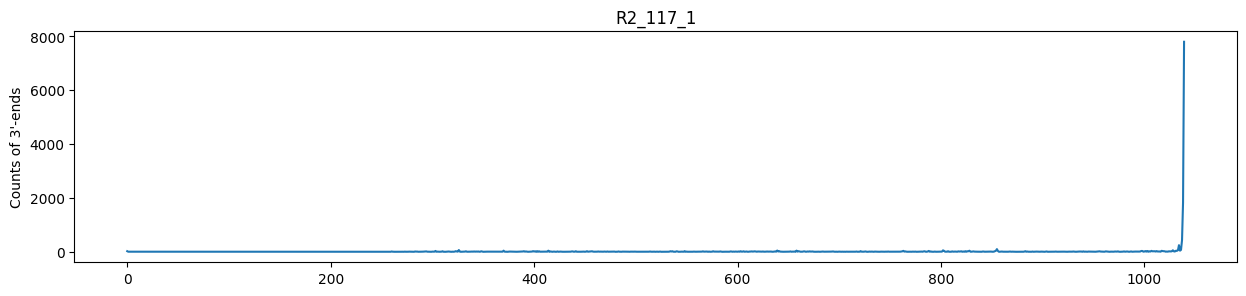

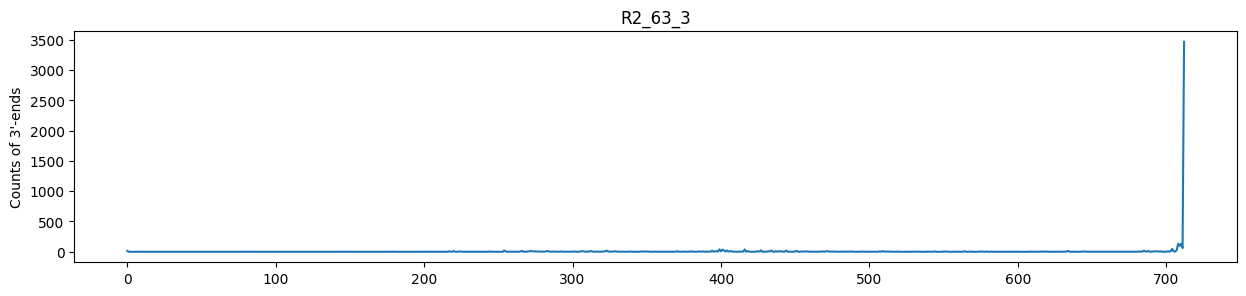

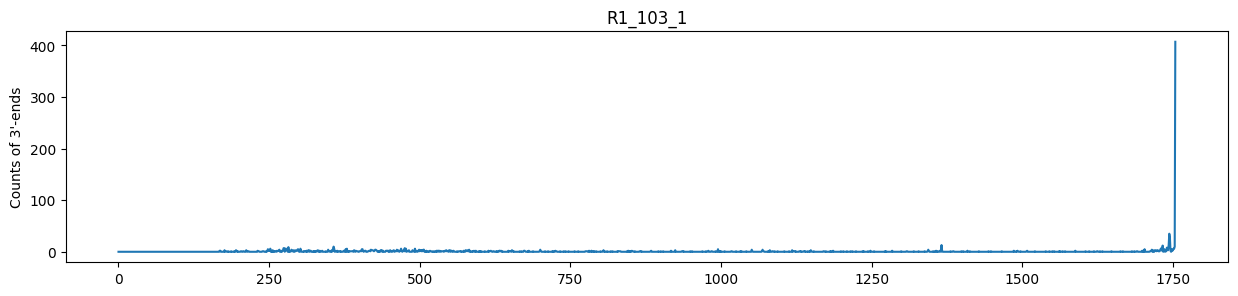

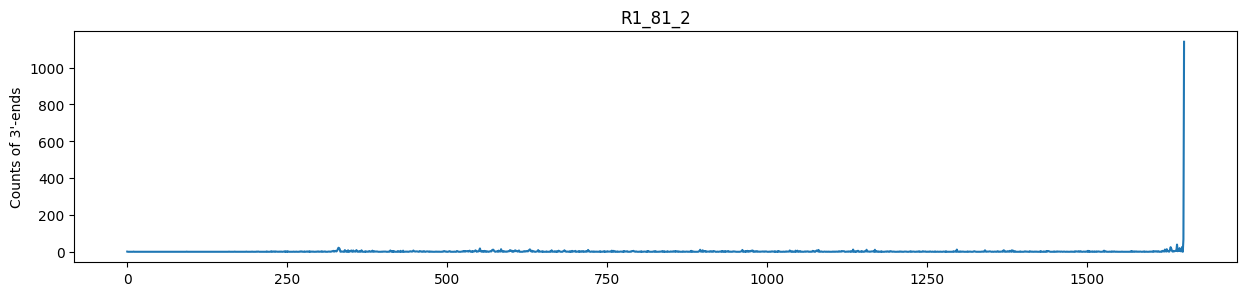

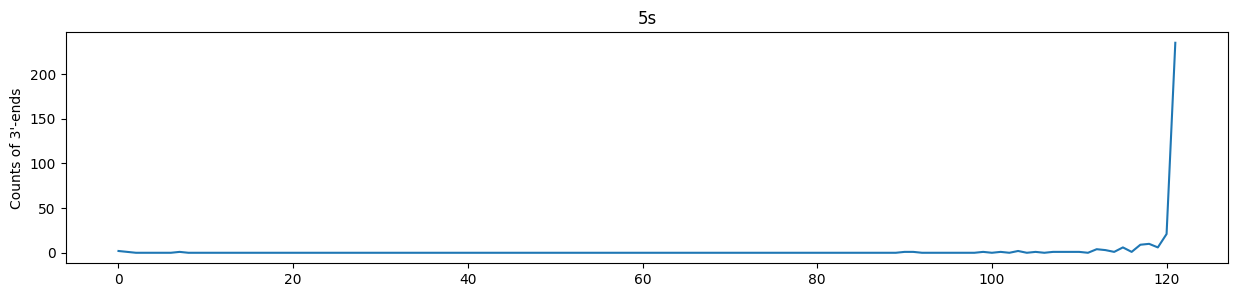

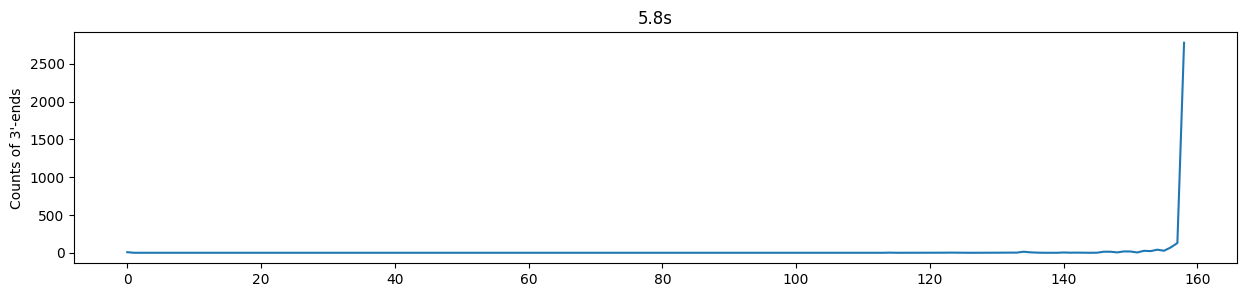

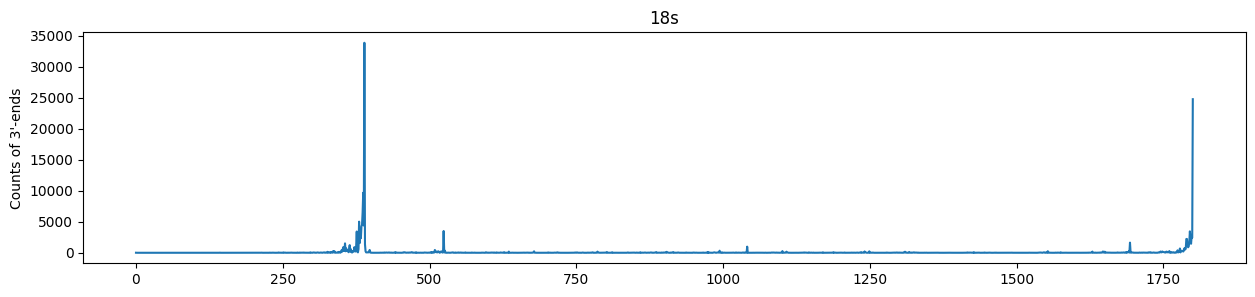

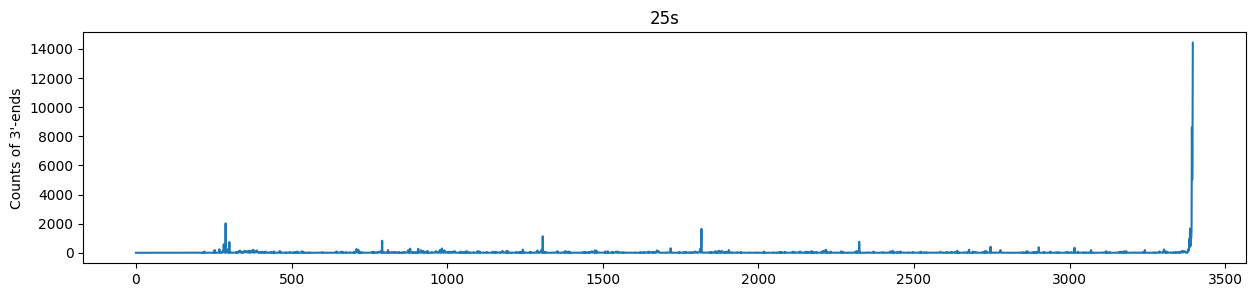

In [21]:
for ref in refs:
    counts = np.zeros(ref2len[ref]+1, dtype="uint16")
    for a in sam.fetch(ref):
        if a.is_secondary or a.is_supplementary or a.mapq<mapq: continue
        e = a.aend if a.is_reverse else a.pos
        counts[e] += 1
    if sum(counts)<10: continue
    fig, ax = plt.subplots(figsize=(15, 3))
    ax.plot(np.arange(len(counts)), counts)
    ax.set_title(ref); ax.set_ylabel("Counts of 3'-ends")

### estimate pT length

In [13]:
primer = "CAGCACCT" + "ACTTGCCTGTCGCTCTATCTGCAGAGCAGAG" + "TTT"
minscore=20; scoring=(2, 3, 3, 2)
match_score, mismatch_penalty, open_penalty, extend_penalty = scoring
matrix = parasail.matrix_create("ACGT", match_score, -mismatch_penalty)
profile = parasail.profile_create_16(primer, matrix)

mapq = 10
data = []
for ref in refs:
    i = 0
    for a in sam.fetch(ref):
        e = a.aend if a.is_reverse else a.pos
        if a.is_secondary or a.is_supplementary or a.mapq<mapq: continue
        i += 1
        read_id = a.qname
        seq, pt_s, pt_e, pt_len, pt_seq, alg_score, alg_identity, cigar = alg2pt(a, primer, profile, open_penalty, extend_penalty)
        data.append((ref, read_id, pt_len, alg_score, alg_identity, cigar, ref2len[ref]-e))
    print(ref, i)
len(data)

R2_117_1 15613
R2_63_3 5415
R1_103_1 1410
R1_81_2 3309
5s 311
5.8s 3223


/tmp/ipykernel_230718/1807139069.py:82: RuntimeWarning: Mean of empty slice.
  pt_len = round(steps[s-extension:e+extension+1].sum()/steps[e+extension+1:].mean() - 2*extension, 1); pt_len
/home/lpryszcz/src/miniforge3/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


18s 446183
25s 174469


649933

In [14]:
df = pd.DataFrame(data, columns=("ref", "read_id", "pt", "score", "identity", "cigar", "dist")); df.head()

,ref,read_id,pt,score,identity,cigar,dist
0,R2_117_1,3e3ff05d-0b43-420d-b302-c4aaa7e60400,-10.0,78,1.000,39=3S,1039
1,R2_117_1,0c3e5e75-abdb-4030-bb2a-44e0c82434b7,1.3,18,1.000,9=33S,1039
2,R2_117_1,ca9cf16f-f64e-45a2-9df1-a79f965d56ff,1.0,71,0.973,34=1D3=5S,1039
3,R2_117_1,23289c6b-f19f-4cc7-b4bb-a5fd0cc8ff9e,2.4,14,0.765,10S4=1X1=1X1=1X4=1I3=15S,1039
4,R2_117_1,f4daf80a-1f3e-4919-a0b4-c20887eb53bd,4.7,73,0.974,36=1I2=3S,1039


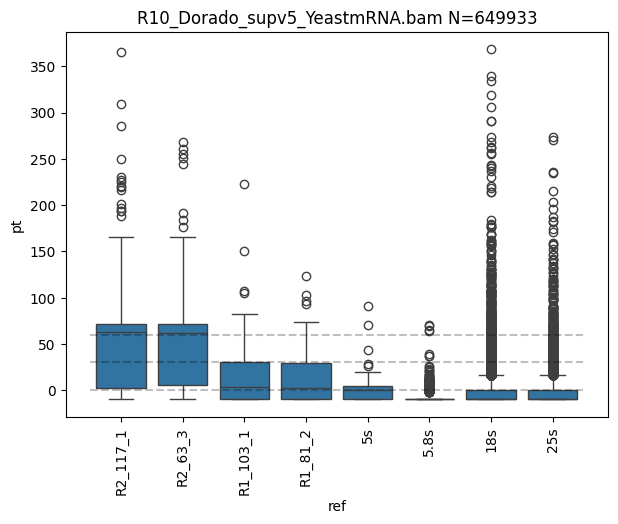

In [47]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df, x="ref", y="pt", ax=ax)
ax.set_title(f"{os.path.basename(bam)} N={len(df)}")
ax.hlines((0, 30, 60), *ax.get_xlim(), ls='--', color="black", alpha=0.25)
_ = plt.xticks(rotation=90)

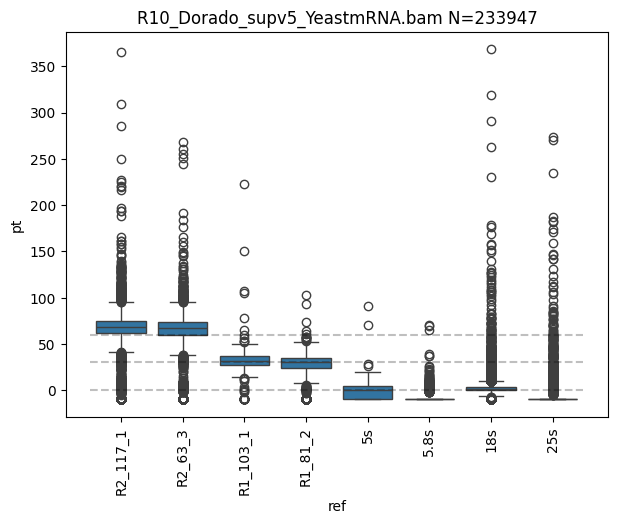

In [48]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df[df.dist<10], x="ref", y="pt", ax=ax)
ax.set_title(f"{os.path.basename(bam)} N={len(df[df.dist<10])}")
ax.hlines((0, 30, 60), *ax.get_xlim(), ls='--', color="black", alpha=0.25)
_ = plt.xticks(rotation=90)

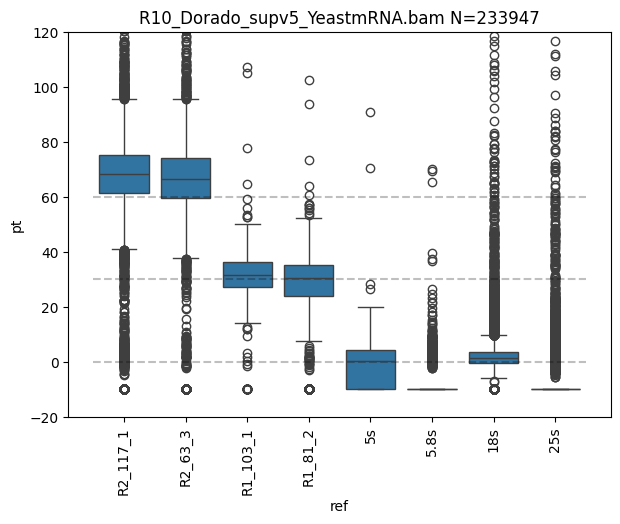

In [49]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.boxplot(data=df[df.dist<10], x="ref", y="pt", ax=ax)
ax.set_title(f"{os.path.basename(bam)} N={len(df[df.dist<10])}")
ax.set_ylim(-20,120)
ax.hlines((0, 30, 60), *ax.get_xlim(), ls='--', color="black", alpha=0.25)
_ = plt.xticks(rotation=90)